In [130]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics

In [131]:
import warnings
warnings.filterwarnings("ignore")   # отключает предупреждения

# считываю файл csv

In [132]:
data = pd.read_csv('/content/output_river.csv').drop('Unnamed: 0', axis = 1) # делаю drop первой колонки
data.head(3) 

,journal,title,ISSN,DOI,authors,affilations,date,pages,abstract,raw_url,keywords
0,International Journal of Fluid Power,Novel concept for stabilising a hydraulic circ...,2332-1180,10.1080/14399776.2016.1172446,"['Jesper K. Sørensen', 'Michael R. Hansen', 'M...","['Faculty of Engineering and Science, Departme...",2016-11-01,NaN,"In this paper, a novel concept for stabilising...",https://journals.riverpublishers.com/index.php...,"['Oscillations', 'counterbalance valve', 'pres..."
1,International Journal of Fluid Power,Open-loop Independent Metering Control of a Mu...,2332-1180,10.13052/ijfp1439-9776.2121,"['Mikko Huova', 'Jyrki Tammisto', 'Matti Li...",['Automation Technology and Mechanical Enginee...,2020-11-04,147–168,This study applies independent metering contro...,https://journals.riverpublishers.com/index.php...,"['independent metering', 'forwarder', 'energy ..."
2,International Journal of Fluid Power,Modelling and experimental validation of the d...,2332-1180,10.1080/14399776.2016.1160718,"['Anthony L. Knutson', 'James D. Van de Ven']","['Department of Mechanical Engineering, Univer...",2016-08-01,114-124,A variety of methods have previously been appl...,https://journals.riverpublishers.com/index.php...,"['Hydraulic valve', 'check valve', 'laser tria..."


In [133]:
data['affilations'][0]   # хранится str

"['Faculty of Engineering and Science, Department of Engineering Sciences, University of Agder, Grimstad, Norway', 'Faculty of Engineering and Science, Department of Engineering Sciences, University of Agder, Grimstad, Norway', 'Faculty of Engineering and Science, Department of Engineering Sciences, University of Agder, Grimstad, Norway']"

# меняю формат кононки affilations

In [134]:
import ast

In [135]:
data['affilations'] = data['affilations'].apply(lambda x: ast.literal_eval(x))  # из строки делаю список строк

In [136]:
data['affilations'] = data['affilations'].apply(lambda x: list(map(lambda y: y.strip(), x)))  # очищаю строки от пробелов по краям 

In [137]:
data['affilations'] = data['affilations'].apply(lambda x: list(set(x)))   # удаляю повторяющиеся аффиляции 

In [138]:
data['affilations'][0]

['Faculty of Engineering and Science, Department of Engineering Sciences, University of Agder, Grimstad, Norway']

In [139]:
data.isna().sum()   # с аффиляциями все в порядке

journal         0
title           0
ISSN            0
DOI            72
authors         0
affilations     0
date            0
pages          21
abstract        0
raw_url         0
keywords        0
dtype: int64

In [140]:
import seaborn as sns

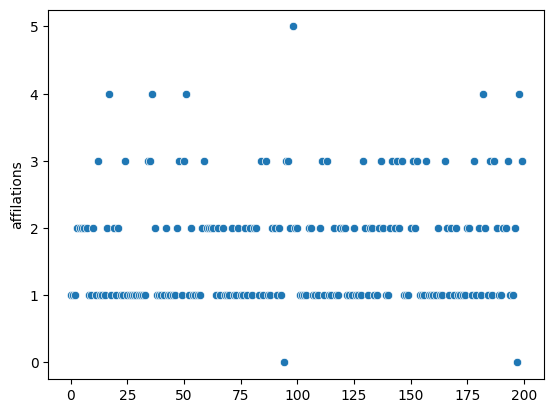

In [141]:
sns.scatterplot(data['affilations'].apply(len));  # диаграмма рассеивания количества аффиляций в статьях

In [142]:
data[data['affilations'].map(len) == 0]

,journal,title,ISSN,DOI,authors,affilations,date,pages,abstract,raw_url,keywords
94,International Journal of Fluid Power,Foreword,2332-1180,NaN,['Fedor Nazarov'],[],2021-11-20,1-1,The 17th Scandinavian International Conference...,https://journals.riverpublishers.com/index.php...,['Foreword']
197,International Journal of Fluid Power,Editorial,2332-1180,NaN,"['Jarosław Stryczek', 'Urszula Warzyńska']",[],2021-02-06,NaN,Polish fluid power conference has been held in...,https://journals.riverpublishers.com/index.php...,['Editorial']


In [143]:
data.drop(data[data['affilations'].map(len) == 0].index, inplace=True)   # убираю строки без аффиляций

# создаю общий список всех аффиляций

In [144]:
af = list(np.concatenate(list(data['affilations'])).flat); af[:9]

['Faculty of Engineering and Science, Department of Engineering Sciences, University of Agder, Grimstad, Norway',
 'Automation Technology and Mechanical Engineering, Tampere University, Korkeakoulunkatu 6, FI-33720, Tampere, Finland',
 'Department of Mechanical Engineering, University of Minnesota, Minneapolis, MN, USA',
 'Universidade da Coruña, Centro de Investigación CITIC, Facultade de Informática, A Coruña, Spain',
 'Enxenio S.L., A Coruña, Spain',
 'The University of Toledo - M.I.M.E. Department, 2801 W. Bancroft St., Toledo, Ohio 43606',
 'Northern Arizona University - M.E. Department, 15600 S. McConnell Dr., Flagstaff, Arizona 86001',
 'Laboratory of Automation and Hydraulic Engineering (AUT ), Tampere University of Technology (TUT), Tampere, Finland',
 'Department of Engineering Design and Production, Aalto University, Espoo, Finland']

In [145]:
len(af) 

333

## модели

# 1-я модель

In [146]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from nltk.tokenize import RegexpTokenizer 

In [147]:
tokenizer = RegexpTokenizer(r'\w+') 

In [148]:
tf_idf_vect = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize) 

In [149]:
X_train_counts = tf_idf_vect.fit_transform(af) 

In [150]:
X_train_counts.shape 

(333, 933)

In [151]:
kmeans = KMeans(n_clusters=100).fit(X_train_counts) 

In [152]:
pred_labels = kmeans.labels_ 

In [153]:
pred_labels.shape

(333,)

In [154]:
# compute DBI score
dbi = metrics.davies_bouldin_score(X_train_counts.toarray(), pred_labels); dbi

1.5530954060096165

In [155]:
# compute Silhoutte Score
ss = metrics.silhouette_score(X_train_counts.toarray(), pred_labels , metric='euclidean'); ss

0.30744280571348415

In [156]:
pairs = dict(zip(af, pred_labels))

In [157]:
import itertools
dict(itertools.islice(pairs.items(), 3))

{'Faculty of Engineering and Science, Department of Engineering Sciences, University of Agder, Grimstad, Norway': 10,
 'Automation Technology and Mechanical Engineering, Tampere University, Korkeakoulunkatu 6, FI-33720, Tampere, Finland': 1,
 'Department of Mechanical Engineering, University of Minnesota, Minneapolis, MN, USA': 30}

In [158]:
data['labels'] = data['affilations'].apply(lambda x: list(set([*map(pairs.get, x)])))

In [159]:
data.iloc[:, [1, 5, 11]].head(15)   # лейблы кластеров проставлены 

,title,affilations,labels
0,Novel concept for stabilising a hydraulic circ...,"[Faculty of Engineering and Science, Departmen...",[10]
1,Open-loop Independent Metering Control of a Mu...,[Automation Technology and Mechanical Engineer...,[1]
2,Modelling and experimental validation of the d...,"[Department of Mechanical Engineering, Univers...",[30]
3,Applying Feature-Oriented Software Development...,"[Universidade da Coruña, Centro de Investigaci...",[79]
4,DESIGN ANALYSIS AND CONTROL OF A MAGNETORHEOLO...,[The University of Toledo - M.I.M.E. Departmen...,[57]
5,Digital hydraulic multi-pressure actuator – th...,[Laboratory of Automation and Hydraulic Engine...,"[1, 46]"
6,REDUCING INFLUENCE OF ECCENTRIC LOAD ON DYNAMI...,"[SMC pneumatic technical Center, Mechanical En...",[12]
7,Model-Driven Skills Assessment in Knowledge Ma...,"[Department of Computer Science, University of...",[60]
8,Method for combining valves with symmetric and...,"[LASHIP, Department of Mechanical Engineering,...",[3]
9,APPLICATION OF EXTENDED KALMAN FILTER IN A MET...,"[Rolf Fluid Power Lab, Mechanical and Aerospac...",[17]


# 2-я модель

In [160]:
vect = CountVectorizer()
bow = vect.fit_transform(af)
bow.shape 

(333, 938)

In [161]:
bow

<333x938 sparse matrix of type '<class 'numpy.int64'>'
	with 3656 stored elements in Compressed Sparse Row format>

In [162]:
terms = vect.get_feature_names_out()
terms[150:170]

array(['aerospace', 'ag', 'agder', 'agency', 'agricultural', 'ain',
       'ainstitute', 'airbus', 'aircraft', 'allison', 'altenbergerstr',
       'altenbergerstrasse', 'ambiente', 'american', 'ames', 'amsterdam',
       'and', 'anglet', 'applications', 'applied'], dtype=object)